# (1) Process Butterfly Data

In [1]:
from utils.data import create_butterfly_dataset
trainset, testset, normal_mapping, reverse_mapping = create_butterfly_dataset()
assert len(trainset) == 12594, 'Size of train set not match'
assert len(testset) == 500, 'Size of test set not match'

# (2) Import Classifier

In [2]:
from model.butterfly_classifier import DenseNet121
import torch

model = DenseNet121(num_classes=len(normal_mapping)).to('cuda')
model.load_state_dict(torch.load('./model/states/butterfly_classifier.pth'))

<All keys matched successfully>

# (3) Evaluate AAA (without true label) against (untargeted) adversarial examples

In [3]:
from algo.attacker import adversarial_generator
from algo.defender import AAAProtectedClassifier
from torch import nn
import numpy as np
import torch.nn.functional as F

test_img, test_label = testset[5]
test_img = test_img.unsqueeze(0)

protected_model = AAAProtectedClassifier(model=model, alpha=0.7, tau=6, kappa=100, T=7, beta=5, lr=0.1, AAA_type='sin')

adv_img = adversarial_generator(model = protected_model,
                                target_class=test_label,
                                 image=test_img, 
                                 search_var=1e-3,
                                 sample_num=50,
                                 bound=0.1,
                                 lr=0.01,
                                 query_limit=3000)

100%|██████████████████████████████████████████████████████████████████████████████████| 60/60 [12:01<00:00, 12.02s/it]


In [6]:
import torch.nn.functional as F

adv_logits = model(adv_img)
org_logits = model(test_img.to('cuda'))

print('Adversarial: predicted class is {}'.format(torch.argmax(adv_logits, dim=1)))
print('Original: predicted class is {}'.format(torch.argmax(org_logits, dim=1)))

print('Adversarial: logit of true class is {}'.format(adv_logits[0, test_label]))
print('Original: logit of true class is {}'.format(org_logits[0, test_label]))

print('Adversarial: probability of true class is {}'.format(F.softmax(adv_logits, dim=1)[0, test_label]))
print('Original: probability of true class is {}'.format(F.softmax(org_logits, dim=1)[0, test_label]))

Adversarial: predicted class is tensor([69], device='cuda:0')
Original: predicted class is tensor([69], device='cuda:0')
Adversarial: logit of true class is -0.43851327896118164
Original: logit of true class is 0.3496592342853546
Adversarial: probability of true class is 0.005355591420084238
Original: probability of true class is 0.011376953683793545


In [5]:
from algo.defender import AAAProtectedClassifier
from torch import nn
import numpy as np
import torch.nn.functional as F

org_logits = model(test_img.to('cuda'))
protected_model = AAAProtectedClassifier(model=model, alpha=0.7, tau=6, kappa=100, T=7, beta=5, lr=0.1, AAA_type='sin')
protected_logits = protected_model(test_img)

In [10]:
protected_logits

tensor([[-0.3593, -0.6319, -0.7040, -0.7968, -0.9556, -1.1817, -0.0523, -1.6349,
         -1.1460, -1.4951, -0.6136, -0.3287, -0.6106,  2.2207, -1.0768, -0.4476,
         -1.1612, -0.2903, -0.8369, -0.9035, -0.7824, -0.6221, -0.3840, -0.0138,
         -1.3055, -1.1783, -0.4000, -0.5156, -0.0289, -0.9264, -0.7073, -1.5496,
          0.2791, -0.0356, -1.0450, -0.4357, -0.8557, -1.0246, -0.8241, -1.1882,
         -0.8205,  0.0200, -1.5732, -0.7396, -1.1709, -0.8736, -0.0791, -0.8486,
          0.1635, -0.5774, -0.8518, -1.2851,  0.4045, -0.1159, -1.7077, -1.2771,
         -0.6497, -1.1795, -1.1638, -0.4768, -0.6759, -0.0642, -0.4284, -1.1815,
         -0.6095, -1.0016, -1.8425, -0.7374, -0.6809,  0.3994,  0.0836, -0.6486,
         -1.0534, -0.2341, -0.0136, -1.5927, -2.2466,  0.1738, -1.2181, -0.9694,
         -2.0358, -0.9131, -1.2035, -0.4589, -0.5532, -1.7411, -1.1804, -1.3397,
         -0.0791, -0.4141, -0.3943, -0.4976, -0.0525, -0.4752, -1.3062, -1.5184,
         -0.9025, -0.5261, -

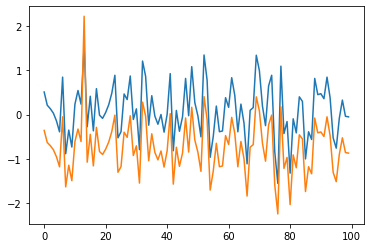

In [9]:
import matplotlib.pyplot as plt
plt.plot(org_logits.view(-1).detach().cpu().numpy())
plt.plot(protected_logits.view(-1).detach().cpu().numpy())
# org_logits